# Testing the two-level asymptotic form of `Whirl2d`

In [89]:
include(joinpath(Pkg.dir("whirl2d"), "src/Whirl2d.jl"))
import Whirl2d
import Whirl2d:@get
using PyPlot
@get Whirl2d (Systems, Grids, DualPatch, Bodies, TimeMarching, NavierStokes);

### Create a body undergoing a weak oscillatory translation in `x` direction 

In [90]:
Npts = 100
rad = 0.5
xcent = [0.0,0.0]
ang = 0.0
b1 = Bodies.Circle(Npts,rad,xcent,ang)
Bodies.set_velocity!(b1,(t,xi)->[cos(t),0.0],1)
Bodies.set_velocity!(b1,(t,xi)->[0.0,0.0],2)

xcent = [2.0,0.0]
ang = 0.0
b2 = Bodies.Circle(Npts,rad,xcent,ang)
Bodies.set_velocity!(b2,(t,xi)->[0.0,0.0],1)
Bodies.set_velocity!(b2,(t,xi)->[0.0,0.0],2)

2-element Array{Function,1}:
 #151
 #153

### Create a domain with this body in it

In [91]:
xmin = [-1.0,-1.0]
xmax = [3.0,1.0]
dom = Systems.DualDomain(xmin,xmax)
dom = Systems.add_body(dom,b1)
dom = Systems.add_body(dom,b2)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 2
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Body: number of points = 100, reference point = (2.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]



#### Add a filling dual grid to this domain
The boundaries of the domain coincide with the boundaries of the dual grid

In [92]:
Δx = 0.02
dom = Systems.add_grid(dom,Δx)

Domain: xmin = [-1.0, -1.0], xmax = [3.0, 1.0]
number of bodies = 2
Body: number of points = 100, reference point = (0.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Body: number of points = 100, reference point = (2.0,0.0), rotation matrix = [1.0 -0.0; 0.0 1.0]

Grid: number of cells = (200,100), Δx = 0.02, xmin = [-1.0, -1.0], xmax = [3.0, 1.0]



### Set the physical and time parameters

In [93]:
Re = 40
physparams = NavierStokes.set_freestream([0.0,0.0])
NavierStokes.set_Re!(physparams,Re)
Δt = min(0.5*Δx,Δx^2*Re)

α = Δt/(Re*Δx^2)
tparams = TimeMarching.TimeParams(Δt,TimeMarching.RK31())

params = (physparams,α)

(Whirl2d.NavierStokes.PhysParams([0.0, 0.0], 40.0), 0.625)

### Compute the grid and body operators
This fills in the LGF and integrating factor tables, computes the interpolation/regularization operators, computes the Schur complement operators and factorizes them, and defines the operators needed for calling the HERK

In [94]:
@time ops = NavierStokes.set_operators_two_level_body!(dom,params);
A⁻¹,L⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂ = ops

 16.289750 seconds (148.49 M allocations: 9.689 GiB, 8.80% gc time)


(Whirl2d.NavierStokes.A⁻¹, Whirl2d.NavierStokes.L⁻¹, Whirl2d.NavierStokes.B₁ᵀ, Whirl2d.NavierStokes.B₂!, Whirl2d.NavierStokes.S⁻¹, Whirl2d.NavierStokes.S₀⁻¹, Whirl2d.NavierStokes.r₁, Whirl2d.NavierStokes.r₂)

### Create an initial solution structure

In [95]:
s = NavierStokes.TwoLevelBodySoln(dom)

Solution: t = 0.0


### Advance the solution

In [99]:
@time for i = 1:20
    s = TimeMarching.ifherk!(s,tparams,A⁻¹,B₁ᵀ,B₂!,S⁻¹,S₀⁻¹,r₁,r₂)
end
s.ψ = -L⁻¹(s.u)

  6.711625 seconds (56.84 M allocations: 3.934 GiB, 13.66% gc time)


2-element Array{Array{Float64,2},1}:
 [-8.41691 -8.41734 … 8.41289 8.40573; -8.58994 -8.59399 … 8.58231 8.57154; … ; -1.0755 -1.05028 … 1.1005 1.12556; -1.06741 -1.0426 … 1.09202 1.11668]                         
 [0.635746 0.648305 … -0.62318 -0.610633; 0.64861 0.661975 … -0.635272 -0.621986; … ; -0.0352767 -0.0345154 … 0.0360272 0.0367688; -0.0347857 -0.0340419 … 0.0355188 0.0362435]

### Plot the solution

#### Level 1 solution

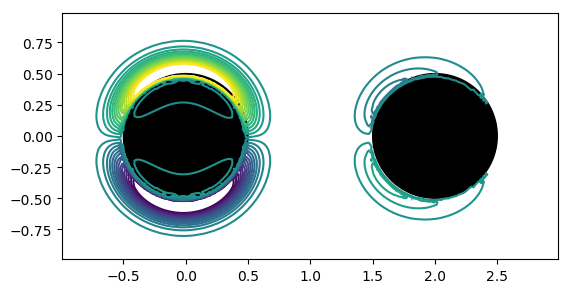

(-0.99, 2.99, -0.99, 0.99)

In [100]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[1][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

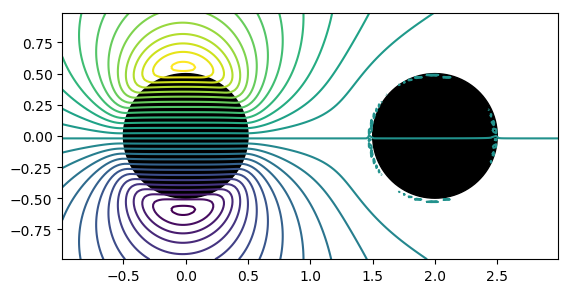

(-0.99, 2.99, -0.99, 0.99)

In [101]:
contour(x,y,s.ψ[1][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

#### Level 2 solution

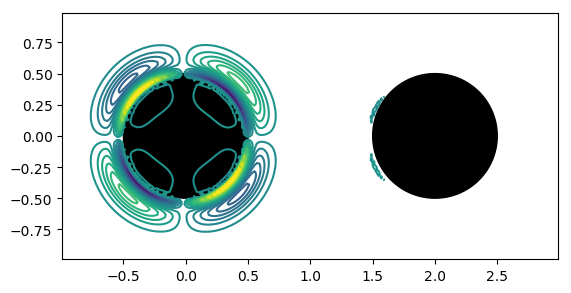

(-0.99, 2.99, -0.99, 0.99)

In [102]:
x = [dom.grid.xmin[1]+Δx*(i-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]
y = [dom.grid.xmin[2]+Δx*(j-1/2) for i=1:dom.grid.N[1], j=1:dom.grid.N[2]]

contour(x,y,s.u[2][dom.grid.cellint[1],dom.grid.cellint[2]]/Δx,linspace(-10,10,30))
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")

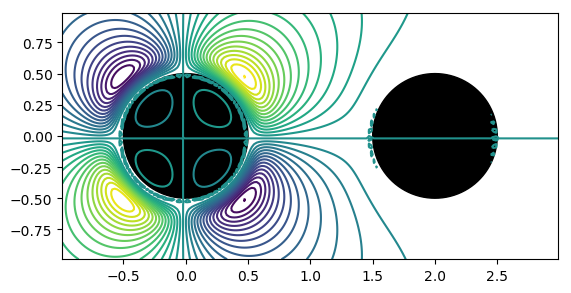

(-0.99, 2.99, -0.99, 0.99)

In [103]:
contour(x,y,s.ψ[2][dom.grid.cellint[1],dom.grid.cellint[2]]*Δx,31)
for j = 1:dom.nbody
    xpt = [dom.body[j].x[i][1] for i = 1:dom.body[j].N]
    ypt = [dom.body[j].x[i][2] for i = 1:dom.body[j].N]
    fill(xpt,ypt,color="k")
end
axis("scaled")